# Uplift Modeling for X5 dataset

**Проект выполнили:**
* Евгений Безмен
* Евгений Туров
* Ильяс Шаймухаметов
* Ярослав Петрик

In [1]:
!pip install -r requirements.txt
from IPython.display import clear_output
import pandas as pd
import numpy as np
clear_output()

## Валидация данных

#### Предобработка данных

In [2]:
# Импорт данных
from sklift.datasets import fetch_x5
dataset = fetch_x5()

clients_df = dataset.data.clients
clients_df = clients_df.set_index('client_id')

purchases_df = dataset.data.purchases
purchases_df = purchases_df.set_index('client_id')

train_df = pd.DataFrame(data= np.c_[dataset.data.train, dataset.treatment, dataset.target],
                     columns= dataset.feature_names.train_features)
train_df = train_df.set_index('client_id')

In [3]:
# Извлечение признаков
features_df = clients_df.copy()
features_df['first_issue_time'] = (pd.to_datetime(features_df['first_issue_date'])
                                   - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
features_df['first_redeem_time'] = (pd.to_datetime(features_df['first_redeem_date'])
                                   - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
features_df['issue_redeem_delay'] = features_df['first_redeem_time'] - features_df['first_issue_time']
features_df = features_df.drop(['first_issue_date', 'first_redeem_date'], axis=1)

avr_check = purchases_df.drop_duplicates('transaction_id').groupby('client_id')['purchase_sum'].mean()
num_purchases = purchases_df.drop_duplicates('transaction_id').groupby('client_id')['transaction_id'].count()
points_spent = -(purchases_df.drop_duplicates('transaction_id').groupby('client_id')['regular_points_spent'].sum() + purchases_df.drop_duplicates('transaction_id').groupby('client_id')['express_points_spent'].sum())

features_df['avr_check'] = features_df.index.map(avr_check)
features_df['num_purchases'] = features_df.index.map(num_purchases)
features_df['points_spent'] = features_df.index.map(points_spent)

train_df = train_df.astype('int64')

In [4]:
features_df.head()

,age,gender,first_issue_time,first_redeem_time,issue_redeem_delay,avr_check,num_purchases,points_spent
client_id,,,,,,,,
000012768d,45,U,1501947648,1.515094e+09,13146559.0,700.750000,4,-0.0
000036f903,72,F,1491832463,1.492951e+09,1118613.0,306.406250,32,-0.0
000048b7a6,68,F,1544880791,NaN,NaN,471.500000,8,-0.0
000073194a,60,F,1495544174,1.511522e+09,15978107.0,564.788235,17,96.0
00007c7133,67,U,1495469828,1.546277e+09,50806825.0,610.894545,11,240.0


In [5]:
train_df.head()

,treatment_flg,target
client_id,,
000012768d,0,1
000036f903,1,1
00010925a5,1,1
0001f552b0,1,1
00020e7b18,1,1


##### Описание переменных

<code>client_id</code> - уникальный идентификатор покупателя

<code>age</code> - возраст (числовая переменная)

<code>gender</code> - пол (категориальная переменная, U - не определен)

<code>first_issue_time</code> - время выпуска карты (числовая переменная)

<code>first_redeem_time</code> - время выкупа карты (числовая переменная)

<code>issue_redeem_delay</code> - разница <code>first_redeem_time</code> и <code>first_issue_time</code> (числовая переменная)

<code>avr_check</code> - средний чек (числовая переменная)

<code>num_purchases</code> - число покупок (числовая переменная)

<code>points_spent</code> - потраченные бонусные баллы (числовая переменная)

<code>treatment_flg</code> - индикатор наличия коммуникации с покупателем (бинарная переменная)

<code>target</code> - целевое действие (бинарная переменная)

#### Оценка переменных

In [6]:
# Проверка на пропуски и повторы в client_id (feature датасет)
print(f"Количество повторов: {len(features_df.index) - len(np.unique(features_df.index))}")
print(f"Количество пропусков: {features_df.index.isnull().sum()}")

Количество повторов: 0
Количество пропусков: 0


In [7]:
# Проверка на пропуски и повторы в client_id (train датасет)
print(f"Количество повторов: {len(train_df.index) - len(np.unique(train_df.index))}")
print(f"Количество пропусков: {train_df.index.isnull().sum()}")

Количество повторов: 0
Количество пропусков: 0


array([[<AxesSubplot:title={'center':'treatment_flg'}>,
        <AxesSubplot:title={'center':'target'}>]], dtype=object)

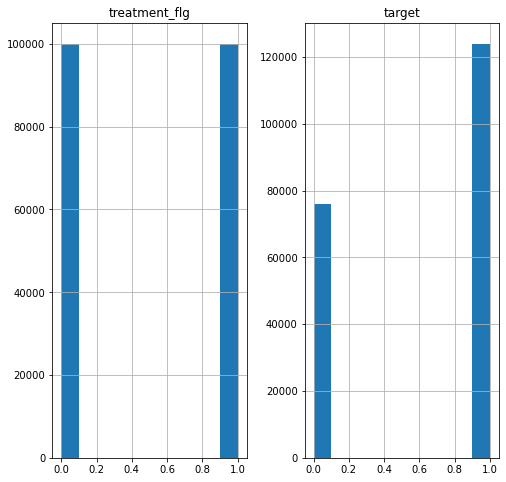

In [8]:
# Размер treatment и control выборок
# Распределение конверсии
train_df.hist(figsize=(8, 8))

In [9]:
# Проверка на пропущенные значения в uplift_train.csv
train_df.isnull().sum()

treatment_flg    0
target           0
dtype: int64

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'first_issue_time'}>,
        <AxesSubplot:title={'center':'first_redeem_time'}>],
       [<AxesSubplot:title={'center':'issue_redeem_delay'}>,
        <AxesSubplot:title={'center':'avr_check'}>,
        <AxesSubplot:title={'center':'num_purchases'}>],
       [<AxesSubplot:title={'center':'points_spent'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

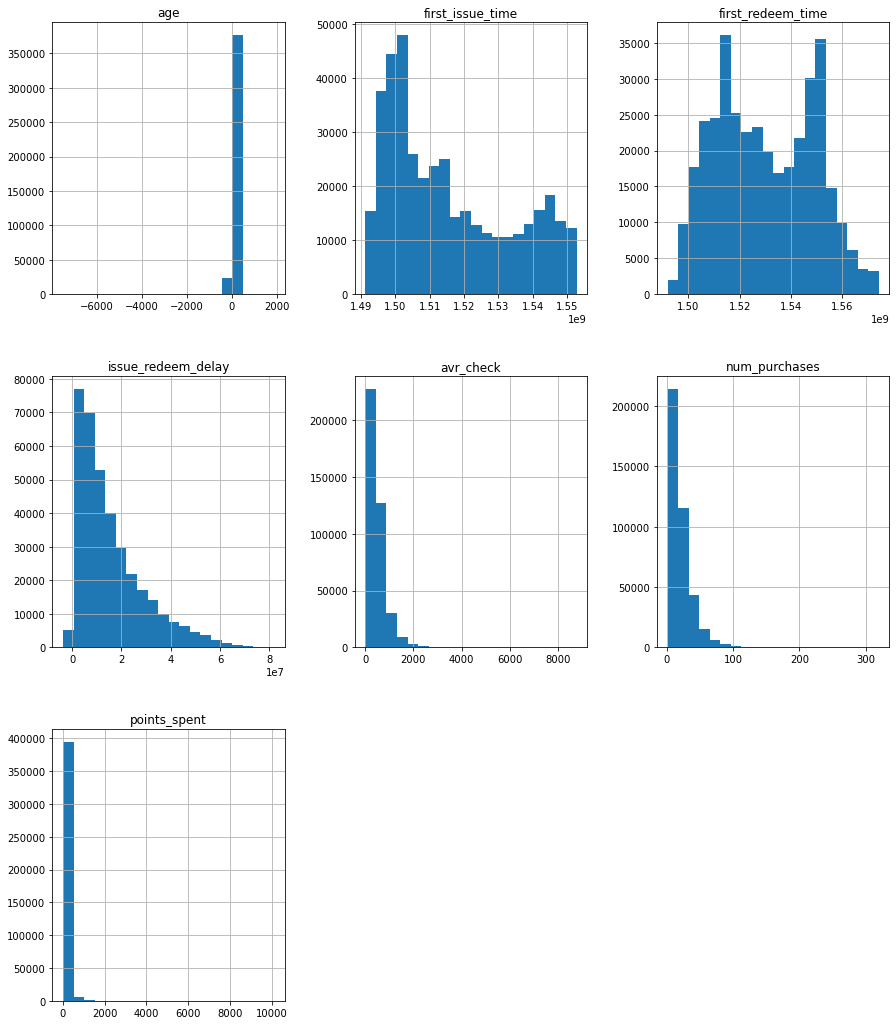

In [10]:
# Распределение признаков
features_df.hist(figsize=(15, 18), bins=20)

In [11]:
# Проверка пропущенных значений в признаках
features_df.isnull().sum()

age                       0
gender                    0
first_issue_time          0
first_redeem_time     35469
issue_redeem_delay    35469
avr_check                 0
num_purchases             0
points_spent              0
dtype: int64

Проблемы:
* В <code>age</code> присутствует отрицательный возраст
* В <code>issue_redeem_delay</code> есть отрицательные значения
* В <code>first_redeem_time</code> и <code>issue_redeem_delay</code> есть пропущенные значения

In [12]:
bad_data = features_df[(features_df['age'] > 120) | (features_df['age'] < 0) | (features_df['issue_redeem_delay'] < 0)].index

In [13]:
# Избавляемся от некорректных строчек в feature и train
features_df = features_df.drop(bad_data, axis=0)
train_df = train_df.drop(train_df.index.intersection(bad_data), axis=0)

In [14]:
features_df.isnull().sum()

age                       0
gender                    0
first_issue_time          0
first_redeem_time     35431
issue_redeem_delay    35431
avr_check                 0
num_purchases             0
points_spent              0
dtype: int64

Настроить обработку пропущенных значений <code>first_redeem_time</code> и соответственно <code>issue_redeem_delay</code> можно в параметрах модели, либо позже вручную.

##### Итог:
* Датасет почищен и готов к использованию, данные валидны
* Соотношение treatment/control сбалансированное, так что в будущем можно применить трансформацию классов
* Учитывая смысл переменной issue_redeem_delay, пропущенные значения в first_redeem_time стоит заменить на максимальные, чтобы issue_redeem_delay была максимальной для каждого id

## Baseline

#### Подготовка данных

In [15]:
# Заменяем пропущенные значения в first_redeem_time и issue_redeem_delay на максимальные
features_df['first_redeem_time'] = features_df['first_redeem_time'].fillna(features_df['first_redeem_time'].max())
features_df['issue_redeem_delay'] = features_df['first_redeem_time'] - features_df['first_issue_time']

In [16]:
from sklearn.model_selection import train_test_split

indices_learn, indices_valid = train_test_split(train_df.index, test_size=0.3, random_state=1)

X_train = features_df.loc[indices_learn, :]
y_train = train_df.loc[indices_learn, 'target']
treat_train = train_df.loc[indices_learn, 'treatment_flg']

X_val = features_df.loc[indices_valid, :]
y_val = train_df.loc[indices_valid, 'target']
treat_val = train_df.loc[indices_valid, 'treatment_flg']

In [17]:
# Для CatBoost
cat_features = ['gender']

#### Построение модели

In [18]:
from sklift.models import TwoModels
from catboost import CatBoostClassifier

baseline = TwoModels(
    estimator_trmnt = CatBoostClassifier(num_trees=30, random_state=111, nan_mode='Forbidden', logging_level='Silent'),
    estimator_ctrl = CatBoostClassifier(num_trees=30, random_state=111, nan_mode='Forbidden', logging_level='Silent'),
    method = 'vanilla'
)

In [19]:
baseline = baseline.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

array([<AxesSubplot:title={'center':'Treatment predictions'}, ylabel='Probability hist'>,
       <AxesSubplot:title={'center':'Control predictions'}>,
       <AxesSubplot:title={'center':'Uplift predictions'}>], dtype=object)

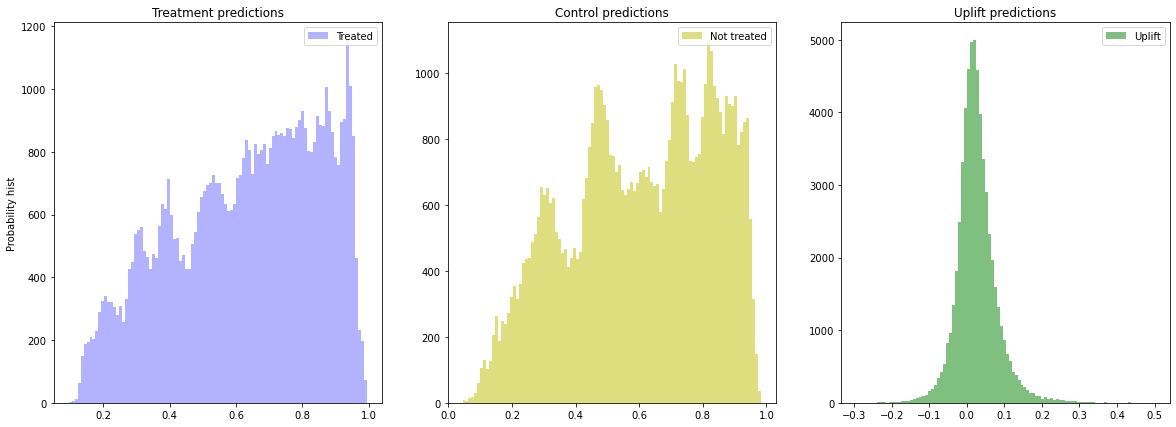

In [20]:
from sklift.viz import plot_uplift_preds

uplift_baseline = baseline.predict(X_val)

# Отрисовка распределения вероятностей и их разности (uplift)
plot_uplift_preds(trmnt_preds=baseline.trmnt_preds_, ctrl_preds=baseline.ctrl_preds_)

#### Метрики

Чем больше в первых перцентилях разница двух response rate, тем больше uplift (красный цвет), а значит, тем лучше модель находит клиентов, которые положительно откликаются на коммуникацию.

D:\Anaconda_Python\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


<AxesSubplot:title={'center':'Uplift by percentile\nweighted average uplift = 0.0354'}, xlabel='Percentile', ylabel='Uplift = treatment response rate - control response rate'>

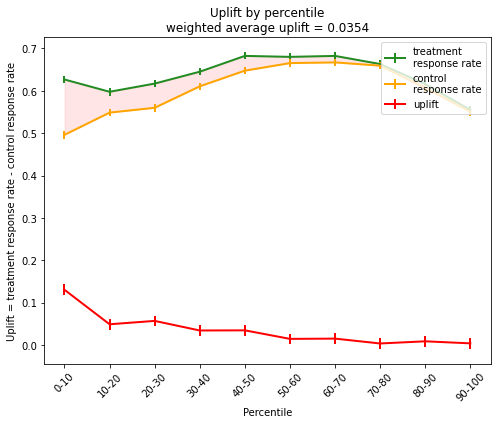

In [21]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_by_percentile

plot_uplift_by_percentile(y_true=y_val, uplift=uplift_baseline, treatment=treat_val, strategy='overall', kind='line')

Посчитаем эффект воздействия коммуникации на 30% самых "перспективных" покупателей

In [22]:
uplift_at_score = uplift_at_k(y_true=y_val, uplift=uplift_baseline, treatment=treat_val, strategy='overall', k=0.3)
print(f"Uplift@30%: {uplift_at_score:.4f}")

Uplift@30%: 0.0787
